Code by: James Sunseri https://github.com/James11222/Simple_Galaxy_Sim

# Import libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from celluloid import Camera
from tqdm import tqdm
import astropy.constants as constant
import astropy.units as unit

# Constants

In [6]:
# Universal gravitational constant
G = constant.G.value
M_sun = constant.M_sun.value

# Helper Functions

In [7]:
def convert_polar_to_cart(θ, r):
    
    """
    Convert from polar to cartesian coordinates.
    """
    
    x = r*np.cos(θ)
    y = r*np.sin(θ)
    
    return np.array([x, y])

def gaussian(x, mu, sig):
    
    """
    Gaussian curve to force a constant rotational velocity curve.
    """
    
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Object Class

In [8]:
class Star:

    """
    Star object with position, velocity, and mass traits.
    """
    
    def __init__(self, position, velocity, mass):
        
        self.position = position
        self.velocity = velocity 
        self.mass = mass
        self.force = 0
        
    def calc_grav_force(self, other_star):
        
        """
        Calculate gravitational force between 2 objects.
        """
        
        # force magnitude
        dr_vec = other_star.position - self.position
        dr = np.linalg.norm(dr_vec)
        F = G * (self.mass * other_star.mass) / (dr)**2  
        
        # condition to "handle" collision instabilities  
        if dr < 5e-2:
            F = 0
   
        # force vector
        F_hat = dr_vec / dr
        self.force += F * F_hat
        
    def calc_acceleration(self):
        self.acceleration = self.force / self.mass

# Building Galaxy

In [33]:
x_hat = np.array([1., 0.])
y_hat = np.array([0., 1.])

def initialize_galaxy(R_inner, R_outer):
    
    mass_star = 1
    
    # initialize polar coordinates of stars
    rs_g = expon.rvs(scale=1.2,loc=R_inner,size=N_stars)
    θs_g = np.random.rand(N_stars) * 360
    polar_coords = np.array([θs_g, rs_g])
    
    # list of star objects
    stars = []
    for i in range(N_stars):
        θ, r = polar_coords[:, i]
        cart_pos = convert_polar_to_cart(θ, r)
        cart_v_0 = np.zeros(2) #initial velocity of 0
        stars.append(Star(cart_pos, cart_v_0, mass_star))
    
    # central black hole
    BH = Star(np.zeros(2), cart_v_0, 1e6 * mass_star)
    return stars, BH

def update_physics_gravity(stars, BH):
    
    """Calculate force of gravity on Nth star from central
    black hole and from other stars.
    """
    # gravity on Nth star due to BH
    for i in range(N_stars):
        stars[i].calc_grav_force(BH)
        # gravity on Nth star due to other stars
        for j in range(N_stars):
            if i != j:
                stars[i].calc_grav_force(stars[j])
    
    # update velocity, acceleration, position
    for i in range(N_stars):
        stars[i].calc_acceleration()
        dv = stars[i].acceleration * dt
        stars[i].velocity = stars[i].velocity + dv
        dpos = stars[i].velocity * dt
        stars[i].position = stars[i].position + dpos

        
"""
ROTATIONAL CURVES

Uncomment function that you want to animate
"""

def update_physics_rotation_curve(stars):
    """
    Rotational curve with 2 options:
    
    1. One that is roughly constant to simulate
    effect of dark matter.
    
    2. One that follows the classical Keplerian behavior.
    
    """
    v_0 = 1
    for i in range(N_stars):
        x, y = stars[i].position
        r = np.sqrt(x**2 + y**2)
        θ_hat = (-y*x_hat + x*y_hat) / r
        #v_θ = v_0 / (10*gaussian(r, 0, 0.4) + 1) # constant velocity
        v_θ = v_0 / np.sqrt(r) # Keplerian behavior
        v = θ_hat * v_θ
        stars[i].velocity = v
        dpos = stars[i].velocity * dt
        stars[i].position = stars[i].position + dpos

# Animation

100%|███████████████████████████████████████████| 40/40 [00:11<00:00,  3.43it/s]
MovieWriter imagemagick unavailable; using Pillow instead.


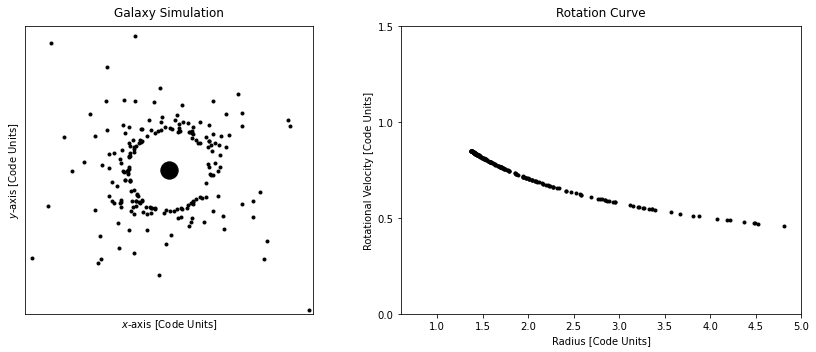

In [34]:
def draw(axes, stars, BH, camera):
    """
    Function for plotting/drawing the motion of the particles with each frame.
    This function takes in an axes object and modifies it.
    """
    #collect all x,y coordinates from all the stars
    xs, ys, rs, vs = [], [], [], []
    for i in range(N_stars):
        x, y = stars[i].position
        r = np.sqrt(x**2 + y**2)
        θ_hat = (-y*x_hat + x*y_hat)/ r
        v_θ = np.abs(np.dot(θ_hat, stars[i].velocity))
        xs.append(x); ys.append(y)
        rs.append(r); vs.append(v_θ)
        
    xs, ys, rs, vs = np.array(xs), np.array(ys), np.array(rs), np.array(vs)
        
    #plot the positions of the stars and the Black Hole
    axes[0].scatter(BH.position[0],BH.position[1], s=300, facecolor="black", edgecolor="black")
    axes[0].scatter(xs, ys, color="black", marker=".")
    
    axes[1].scatter(rs, vs, color="black", marker=".")
    camera.snap()

def main():
    """
    Main loop hosted within this function. This runs the entire simulation.
    """

    # setup the galaxy
    galaxy, BH = initialize_galaxy(R_inner, R_outer)

    # create the figure
    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # left panel (positions)
    axes[0].set_xlim(-R_outer, R_outer); axes[0].set_ylim(-R_outer, R_outer)
    axes[0].set_xticks([]); axes[0].set_yticks([])
    axes[0].set_xticklabels([]); axes[0].set_yticklabels([])
    axes[0].set_aspect('equal')
    axes[0].set_title("Galaxy Simulation", pad = 10)
    axes[0].set_xlabel("$x$-axis [Code Units]")
    axes[0].set_ylabel("$y$-axis [Code Units]")

    # right panel (positions)
    axes[1].set_xlim(R_inner, R_outer)
    axes[1].set_title("Rotation Curve", pad = 10)
    axes[1].set_xlabel("Radius [Code Units]")
    axes[1].set_ylabel("Rotational Velocity [Code Units]")
    axes[1].set_yticks([0.0, 0.5, 1.0, 1.5])
    axes[1].set_ylim(0, 1.5)
    plt.tight_layout()
    camera = Camera(fig)

    #Main Loop for Simulation!
    for frame in tqdm(range(N_frames)):
        draw(axes, galaxy, BH, camera)
        update_physics_rotation_curve(galaxy)
        update_physics_gravity(galaxy, BH)

    animation = camera.animate(blit=True)

    #save animation
    animation.save('GalaxyTEST.gif', writer = 'imagemagick')
    
#Simulation Parameters
N_frames = 40 #number of frames for animation
N_stars = 200 #number of stars to use in our N-body sim
dt = 0.1 #time step size
R_inner, R_outer = 0.6, 5 #inner and outer bounds for stars to be formed in

if __name__ == "__main__": main()